------------------------------------


In [1]:
!pip install -q -U optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 9.9 MB/s eta 0:00:00:00:01


In [2]:
!pip install -q -U keras-tuner

In [3]:
%pip install -q tensorflow

Note: you may need to restart the kernel to use updated packages.


# 1: Import Libraries

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder
import optuna
import keras_tuner as kt
print("TensorFlow Version:", tf.__version__)
print("Keras Version:", keras.__version__)

2025-04-18 19:47:12.938272: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745005633.150130      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745005633.207828      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow Version: 2.18.0
Keras Version: 3.5.0


In [5]:
# from google.colab import drive
# drive.mount('/content/drive')

# 2: Define Data Paths and Load Data

In [6]:
base_path = "/kaggle/input/cassava-leaf-disease-classification"
train_images_path = os.path.join(base_path, 'train_images')
train_labels_path = os.path.join(base_path, 'train.csv')

try:
    train_df = pd.read_csv(train_labels_path)
    print("Training data loaded successfully.")
except FileNotFoundError:
    print(f"Error: train.csv not found at {train_labels_path}. Please ensure the path is correct.")
    train_df = None

if train_df is not None:
    print(f"Shape of training data: {train_df.shape}")
    print("First few rows of training data:")
    print(train_df.head())

Training data loaded successfully.
Shape of training data: (21397, 2)
First few rows of training data:
         image_id  label
0  1000015157.jpg      0
1  1000201771.jpg      3
2   100042118.jpg      1
3  1000723321.jpg      1
4  1000812911.jpg      3


# 3: Data Exploration and Preprocessing


Summary of training data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21397 entries, 0 to 21396
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  21397 non-null  object
 1   label     21397 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 334.5+ KB
None

Number of unique classes:
5

Class distribution:
label
3    13158
4     2577
2     2386
1     2189
0     1087
Name: count, dtype: int64


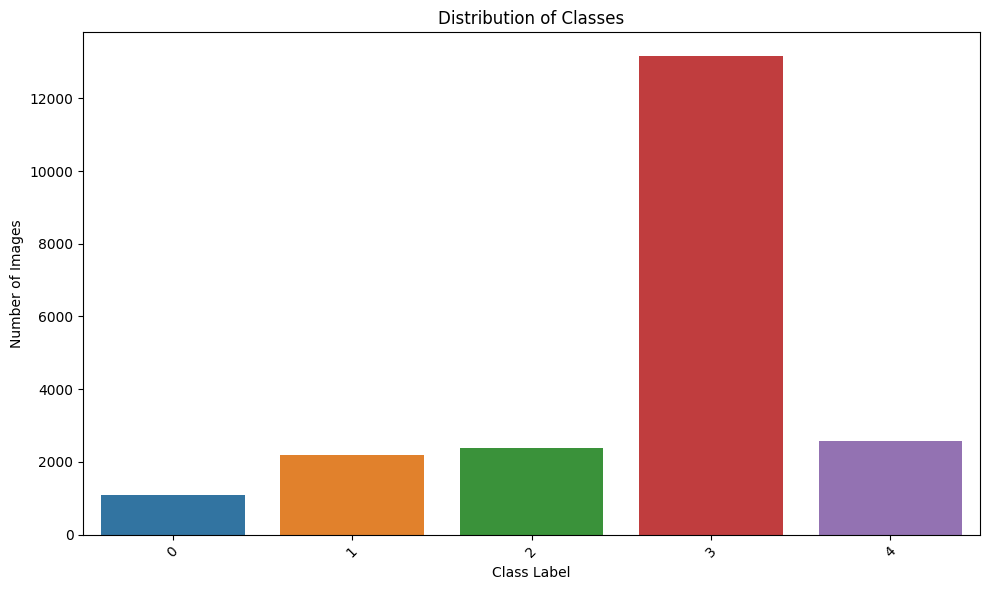

In [7]:
# Summary of Training Data
if train_df is not None:
    print("\nSummary of training data:")
    print(train_df.info())

    print("\nNumber of unique classes:")
    print(train_df['label'].nunique())

    print("\nClass distribution:")
    print(train_df['label'].value_counts())

    # Visualize class distribution
    plt.figure(figsize=(10, 6))
    sns.countplot(data=train_df, x='label')
    plt.title('Distribution of Classes')
    plt.xlabel('Class Label')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# 4: Display Sample Images

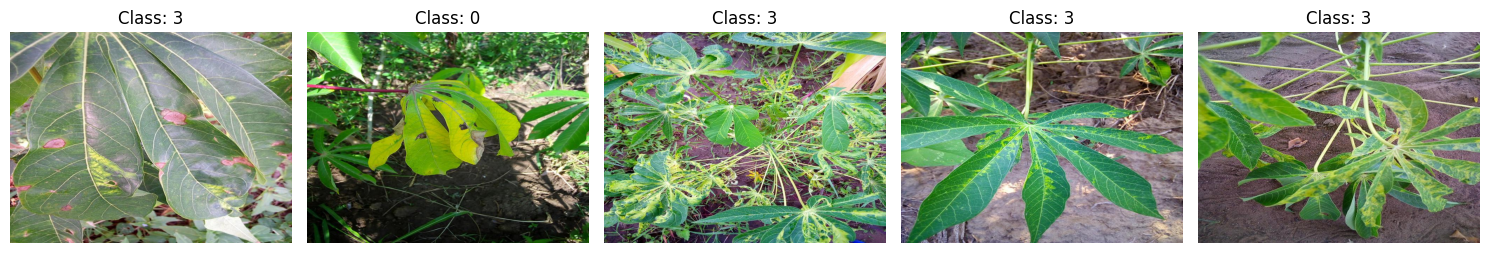

In [8]:

if train_df is not None:
    num_samples = 5
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    for i in range(num_samples):
        random_index = np.random.randint(0, len(train_df))
        image_id = train_df['image_id'][random_index]
        label = train_df['label'][random_index]
        image_path = os.path.join(train_images_path, image_id)
        try:
            img = Image.open(image_path)
            axes[i].imshow(img)
            axes[i].set_title(f"Class: {label}")
            axes[i].axis('off')
        except FileNotFoundError:
            print(f"Error: Image not found at {image_path}")
    plt.tight_layout()
    plt.show()

# 5. Data Augmentation

# Image Parameters and Augmentation Strategies

In [ ]:

if train_df is not None:
    IMG_SIZE = 224
    BATCH_SIZE = 32
    NUM_CLASSES = train_df['label'].nunique()

    # Convert labels to string for ImageDataGenerator
    train_df['label'] = train_df['label'].astype(str)

    # Split data into training and validation sets
    train_data, val_data = train_test_split(train_df, test_size=0.2, stratify=train_df['label'], random_state=42)

    # Data augmentation for the training set to handle class imbalance and improve generalization
    train_datagen = ImageDataGenerator(
        rescale=1./255, # Rescale pixel values to [0, 1]
        rotation_range=45, # Randomly rotate images by up to 45 degrees
        width_shift_range=0.3, # Randomly shift images horizontally by up to 30% of the image width
        height_shift_range=0.3, # Randomly shift images vertically by up to 30% of the image height
        shear_range=0.25,   # Randomly apply shearing transformations
        zoom_range=0.25,    # Randomly apply zoom transformations
        horizontal_flip=True,   # Randomly flip images horizontally
        vertical_flip=True,     # Randomly flip images vertically
        brightness_range=[0.8, 1.2],    # Randomly adjust brightness
        channel_shift_range=50.0,   # Randomly shift the values of each channel
        fill_mode='nearest' # Method for filling in newly created pixels
    )

    # Only rescaling for the validation set
    val_datagen = ImageDataGenerator(rescale=1./255)

    # Create data generators
    train_generator = train_datagen.flow_from_dataframe(
        train_data, # DataFrame containing image paths and labels
        directory=train_images_path, # Directory where images are stored
        x_col='image_id',
        y_col='label',
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='sparse',    # Output classes as sparse integers
        shuffle=True,
        seed=42
    )

    val_generator = val_datagen.flow_from_dataframe(
        val_data,   # Validation DataFrame
        directory=train_images_path,
        x_col='image_id',
        y_col='label',
        target_size=(IMG_SIZE, IMG_SIZE),   # Resize images to match model input size
        batch_size=BATCH_SIZE,   # Batch size for validation data
        class_mode='sparse'
    )

    print(f"\nNumber of training batches: {len(train_generator)}")
    print(f"Number of validation batches: {len(val_generator)}")

Found 17117 validated image filenames belonging to 5 classes.
Found 4280 validated image filenames belonging to 5 classes.

Number of training batches: 535
Number of validation batches: 134


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 224  # You can adjust the size if needed
BATCH_SIZE = 32

# Test images directory
test_images_dir = '/kaggle/input/cassava-leaf-disease-classification'

# Data rescaling only for the test set (no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)   # Rescale pixel values to [0, 1]

# Create test generator
test_generator = test_datagen.flow_from_directory(
    test_images_dir,
    target_size=(IMG_SIZE, IMG_SIZE),  # Resize images to match model input size
    batch_size=BATCH_SIZE,
    class_mode=None,
    shuffle=False    # No need to shuffle test data
)

print(f"Number of test batches: {len(test_generator)}")


Found 21398 images belonging to 4 classes.
Number of test batches: 669


#  6: CNN Architecture + Hyperparameter Tuning
#  Define a Simple CNN Model

In [ ]:
if train_generator is not None:
  # Import the Sequential class
    from tensorflow.keras.models import Sequential

    def create_cnn_model(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=NUM_CLASSES):
        model = Sequential([
            layers.Conv2D(33, (3, 3), activation='relu', input_shape=input_shape),  # 33 filters
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(66, (3, 3), activation='relu'), # 66 filters
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(122, (3, 3), activation='relu'),  # 122 filters
            layers.MaxPooling2D((2, 2)),
            layers.Flatten(),
            layers.Dense(128, activation='relu'),  # 128 neurons
            layers.Dense(num_classes, activation='softmax')  # Output layer with softmax activation
        ])
        return model

    cnn_model = create_cnn_model()
    cnn_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1745005726.374690      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 33)        │             924 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 33)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 66)        │          19,668 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 66)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 122)         │          72,590 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 122)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 82472)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      10,556,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,650,371 (40.63 MB)

 Trainable params: 10,650,371 (40.63 MB)

 Non-trainable params: 0 (0.00 B)

# 6.1: Hyperparameter Tuning for CNN using Keras Tuner

In [ ]:
if train_generator is not None:
    def build_cnn_tuner(hp):
        model = Sequential()
        model.add(layers.Conv2D(
            filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=32),  # Number of filters
            kernel_size=hp.Choice('conv_1_kernel', values=[3, 5]),
            activation='relu',  # Rectified Linear Unit activation function
            input_shape=(IMG_SIZE, IMG_SIZE, 3)
        ))
        model.add(layers.MaxPooling2D((2, 2)))  # Max pooling layer

        for i in range(hp.Int('num_conv_layers', 1, 3)):    # Number of convolutional layers
            model.add(layers.Conv2D(
                filters=hp.Int(f'conv_{i+2}_filter', min_value=32, max_value=128, step=32),
                kernel_size=hp.Choice(f'conv_{i+2}_kernel', values=[3, 5]),
                activation='relu'
            ))
            model.add(layers.MaxPooling2D((2, 2)))  # Max pooling

        model.add(layers.Flatten())
        model.add(layers.Dense(
            units=hp.Int('dense_1_units', min_value=64, max_value=256, step=64),
            activation='relu'
        ))
        model.add(layers.Dense(NUM_CLASSES, activation='softmax'))

        model.compile(
            optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),    # Optimizer
            loss='sparse_categorical_crossentropy',  # Loss function
            metrics=['accuracy']    # Metrics to evaluate the model
        )
        return model

    tuner_cnn = kt.RandomSearch(
        build_cnn_tuner,
        objective='val_accuracy',    # Objective to optimize
        max_trials=2,    # Maximum number of trials
        directory='cnn_tuner'    # Directory to save the results
    )

    tuner_cnn.search(train_generator,
                     steps_per_epoch=train_generator.samples // BATCH_SIZE, # Training steps
                     epochs=5,  # Number of epochs
                     validation_data=val_generator,
                     validation_steps=val_generator.samples // BATCH_SIZE,  # Validation steps
                     callbacks=[EarlyStopping(patience=3)]) # Early stopping callback

    best_hps_cnn = tuner_cnn.get_best_hyperparameters(num_trials=1)[0]
    best_cnn_model = tuner_cnn.hypermodel.build(best_hps_cnn)
    best_cnn_model.summary()

    print(f"\nBest CNN hyperparameters found:\n{best_hps_cnn.values}")

Trial 2 Complete [00h 12m 24s]
val_accuracy: 0.6313439607620239

Best val_accuracy So Far: 0.6414473652839661
Total elapsed time: 00h 22m 50s


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 220, 220, 32)        │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 110, 110, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 108, 108, 128)       │          36,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 54, 54, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 52, 52, 32)          │          36,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 26, 26, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 21632)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       5,538,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,615,653 (21.42 MB)

 Trainable params: 5,615,653 (21.42 MB)

 Non-trainable params: 0 (0.00 B)


Best CNN hyperparameters found:
{'conv_1_filter': 32, 'conv_1_kernel': 5, 'num_conv_layers': 2, 'conv_2_filter': 128, 'conv_2_kernel': 3, 'dense_1_units': 256, 'learning_rate': 0.00012165541012624621, 'conv_3_filter': 32, 'conv_3_kernel': 3}


Epoch 1/10
534/534 ━━━━━━━━━━━━━━━━━━━━ 243s 444ms/step - accuracy: 0.6087 - loss: 1.1485 - val_accuracy: 0.6377 - val_loss: 1.0453
Epoch 2/10
  1/534 ━━━━━━━━━━━━━━━━━━━━ 17s 32ms/step - accuracy: 0.6875 - loss: 0.9907

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


534/534 ━━━━━━━━━━━━━━━━━━━━ 0s 610us/step - accuracy: 0.6875 - loss: 0.9907 - val_accuracy: 0.5833 - val_loss: 1.1101
Epoch 3/10
534/534 ━━━━━━━━━━━━━━━━━━━━ 242s 447ms/step - accuracy: 0.6293 - loss: 1.0295 - val_accuracy: 0.6595 - val_loss: 0.9888
Epoch 4/10
534/534 ━━━━━━━━━━━━━━━━━━━━ 0s 142us/step - accuracy: 0.6250 - loss: 1.0295 - val_accuracy: 0.6667 - val_loss: 1.0686
Epoch 5/10
534/534 ━━━━━━━━━━━━━━━━━━━━ 243s 449ms/step - accuracy: 0.6613 - loss: 0.9457 - val_accuracy: 0.6633 - val_loss: 0.9228
Epoch 6/10
534/534 ━━━━━━━━━━━━━━━━━━━━ 0s 141us/step - accuracy: 0.6250 - loss: 1.1066 - val_accuracy: 0.6667 - val_loss: 0.8995
Epoch 7/10
534/534 ━━━━━━━━━━━━━━━━━━━━ 240s 445ms/step - accuracy: 0.6599 - loss: 0.9173 - val_accuracy: 0.6647 - val_loss: 0.9385
Epoch 8/10
534/534 ━━━━━━━━━━━━━━━━━━━━ 0s 150us/step - accuracy: 0.6875 - loss: 0.7856 - val_accuracy: 0.7083 - val_loss: 1.0447
Epoch 9/10
534/534 ━━━━━━━━━━━━━━━━━━━━ 243s 449ms/step - accuracy: 0.6689 - loss: 0.8926 - val

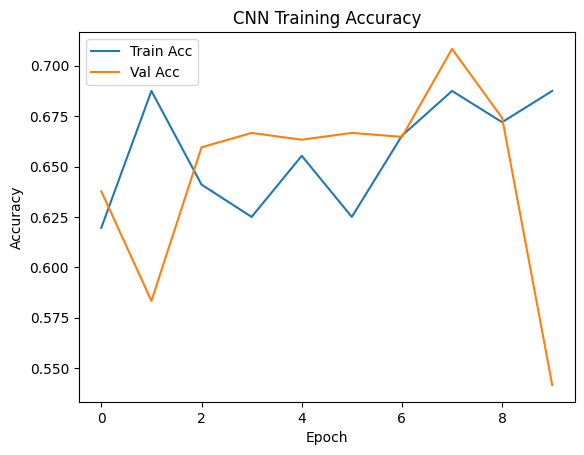

In [ ]:
# Retrain Best Model & Save History
history = best_cnn_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=10,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    callbacks=[EarlyStopping(patience=3)]
)

# Save the Best Model
best_cnn_model.save('new_best_cnn_model.h5')

# Save Training History
with open('cnn_training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

# Plot Accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('CNN Training Accuracy')
plt.legend()
plt.show()

In [ ]:
# Save the trained best CNN model to a file
model_path = 'best_cnn_model.h5'

if 'best_cnn_model' in globals():
    best_cnn_model.save(model_path)  # Save the model
    print(f"Model successfully saved to {model_path}")
else:
    print("Error: best_cnn_model is not defined.")


Model successfully saved to best_cnn_model.h5


In [ ]:
import pickle

# Save the trained best CNN model to a .pkl file
pkl_model_path = 'best_cnn_model.pkl'

if 'best_cnn_model' in globals():
    # Save the model using Pickle
    with open(pkl_model_path, 'wb') as pkl_file:
        pickle.dump(best_cnn_model, pkl_file)
    print(f"Model successfully saved to {pkl_model_path}")
else:
    print("Error: best_cnn_model is not defined.")


Model successfully saved to best_cnn_model.pkl


# 7. Pre-trained Model (EfficientNet) + Hyperparameter Tuning and Optimization

In [ ]:
# Define and Load EfficientNet Model

from tensorflow.keras.models import Model

if train_generator is not None:
    def create_efficientnet_model(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=NUM_CLASSES, trainable_layers=-1):
        base_model = tf.keras.applications.EfficientNetB0(include_top=False, weights='imagenet',    # Pretrained weights
  input_shape=input_shape)  # Base model without top layers

        # Freeze layers
        if trainable_layers > 0:
            for layer in base_model.layers[:-trainable_layers]:
                layer.trainable = False
        elif trainable_layers == -1:
            for layer in base_model.layers:
                layer.trainable = False

        # Custom classification head
        x = base_model.output   # Add custom layers
        x = layers.GlobalAveragePooling2D()(x)  
        x = layers.Dense(128, activation='relu')(x) 
        outputs = layers.Dense(num_classes, activation='softmax')(x)    # Output layer with softmax activation

        model = Model(inputs=base_model.input, outputs=outputs)
        return model

    efficientnet_model = create_efficientnet_model()
    efficientnet_model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 4,214,184 (16.08 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

# 7.1: Hyperparameter Tuning for EfficientNet using Keras Tuner

In [ ]:
if train_generator is not None:
    def build_efficientnet_tuner(hp):
        base_model = tf.keras.applications.EfficientNetB0(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))

        # Freeze base model layers
        for layer in base_model.layers:
            layer.trainable = False

        # Custom classification head
        x = base_model.output
        x = layers.GlobalAveragePooling2D()(x)
        dense_units = hp.Int('dense_units', min_value=64, max_value=256, step=64)
        x = layers.Dense(dense_units, activation='relu')(x)
        outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

        model = Model(inputs=base_model.input, outputs=outputs)

        lr = hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, sampling='LOG')
        model.compile(optimizer=Adam(learning_rate=lr),
                      loss='sparse_categorical_crossentropy',   # Loss function
                      metrics=['accuracy']) # Metrics to evaluate the model
        return model

    tuner_efficientnet = kt.RandomSearch(
        build_efficientnet_tuner,       # Hypermodel builder function
        objective='val_accuracy',    # Objective to optimize
        max_trials=2,    # Maximum number of trials
        directory='efficientnet_tuner'  
    )

    tuner_efficientnet.search(train_generator,
                              steps_per_epoch=train_generator.samples // BATCH_SIZE,
                              epochs=5,
                              validation_data=val_generator,
                              validation_steps=val_generator.samples // BATCH_SIZE,
                              callbacks=[EarlyStopping(patience=2)])

    best_hps_efficientnet = tuner_efficientnet.get_best_hyperparameters(num_trials=1)[0]
    best_efficientnet_model = tuner_efficientnet.hypermodel.build(best_hps_efficientnet)
    best_efficientnet_model.summary()

    print(f"\nBest EfficientNet hyperparameters found:\n{best_hps_efficientnet.values}")

Trial 2 Complete [00h 08m 44s]
val_accuracy: 0.615366518497467

Best val_accuracy So Far: 0.6156014800071716
Total elapsed time: 00h 17m 36s


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_2 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_1           │ (None, 224, 224, 3)    │              7 │ rescaling_2[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_3 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_3[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 4,214,184 (16.08 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)


Best EfficientNet hyperparameters found:
{'dense_units': 128, 'learning_rate': 0.0001737701285311022}


# 7.2: Train the Best EfficientNet Model

In [16]:
import os
import pickle


if train_generator is not None and best_efficientnet_model is not None:
    epochs_efficientnet = 12  # Adjust as needed for Colab free T4 GPU
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

    # Train the model
    history_efficientnet = best_efficientnet_model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // BATCH_SIZE,
        epochs=epochs_efficientnet,
        validation_data=val_generator,
        validation_steps=val_generator.samples // BATCH_SIZE,
        callbacks=[early_stopping, reduce_lr]
    )

    # Save the trained model only if it hasn't been saved before
    model_path = 'best_efficientnet_model.h5'
    if not os.path.exists(model_path):  # Check if the model already exists
        best_efficientnet_model.save(model_path)
        print(f"Best EfficientNet model saved to {model_path}")
    else:
        print("Model already saved, skipping saving step.")

    # Save the trained model to .pkl file
    efficientnet_pkl_model_path = 'best_efficientnet_model.pkl'
    if not os.path.exists(efficientnet_pkl_model_path):  # Check if Pickle model already exists
        with open(efficientnet_pkl_model_path, 'wb') as pkl_file:
            pickle.dump(best_efficientnet_model, pkl_file)
        print(f"Best EfficientNet model saved to {efficientnet_pkl_model_path}")
    else:
        print("Pickle model already saved, skipping saving step.")


Epoch 1/12
534/534 ━━━━━━━━━━━━━━━━━━━━ 277s 471ms/step - accuracy: 0.6007 - loss: 1.2479 - val_accuracy: 0.6149 - val_loss: 1.1844 - learning_rate: 1.7377e-04
Epoch 2/12
534/534 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6875 - loss: 1.0595 - val_accuracy: 0.6250 - val_loss: 1.1325 - learning_rate: 1.7377e-04
Epoch 3/12
534/534 ━━━━━━━━━━━━━━━━━━━━ 240s 444ms/step - accuracy: 0.6168 - loss: 1.1830 - val_accuracy: 0.6142 - val_loss: 1.1845 - learning_rate: 1.7377e-04
Epoch 4/12
534/534 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step - accuracy: 0.5000 - loss: 1.3819 - val_accuracy: 0.7500 - val_loss: 0.9789 - learning_rate: 1.7377e-04
Epoch 5/12
534/534 ━━━━━━━━━━━━━━━━━━━━ 241s 446ms/step - accuracy: 0.6159 - loss: 1.1841 - val_accuracy: 0.6149 - val_loss: 1.1841 - learning_rate: 1.7377e-04
Epoch 6/12
534/534 ━━━━━━━━━━━━━━━━━━━━ 0s 183us/step - accuracy: 0.6875 - loss: 1.0293 - val_accuracy: 0.6250 - val_loss: 1.1967 - learning_rate: 1.7377e-04
Epoch 7/12
534/534 ━━━━━━━━━━━━━━━━━━━━ 239s 441

Epoch 1/12
534/534 ━━━━━━━━━━━━━━━━━━━━ 244s 449ms/step - accuracy: 0.6162 - loss: 1.1827 - val_accuracy: 0.6147 - val_loss: 1.1831 - learning_rate: 6.9508e-06
Epoch 2/12
534/534 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step - accuracy: 0.6875 - loss: 1.0259 - val_accuracy: 0.6667 - val_loss: 1.1549 - learning_rate: 6.9508e-06
Epoch 3/12
534/534 ━━━━━━━━━━━━━━━━━━━━ 242s 448ms/step - accuracy: 0.6125 - loss: 1.1885 - val_accuracy: 0.6149 - val_loss: 1.1830 - learning_rate: 6.9508e-06
Epoch 4/12
534/534 ━━━━━━━━━━━━━━━━━━━━ 0s 157us/step - accuracy: 0.6562 - loss: 1.0759 - val_accuracy: 0.6250 - val_loss: 1.1593 - learning_rate: 6.9508e-06
Epoch 5/12
534/534 ━━━━━━━━━━━━━━━━━━━━ 240s 444ms/step - accuracy: 0.6160 - loss: 1.1820 - val_accuracy: 0.6147 - val_loss: 1.1832 - learning_rate: 6.9508e-06
Epoch 6/12
534/534 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - accuracy: 0.6562 - loss: 1.1012 - val_accuracy: 0.6667 - val_loss: 1.1222 - learning_rate: 1.3902e-06
Epoch 7/12
534/534 ━━━━━━━━━━━━━━━━━━━━ 241s 4

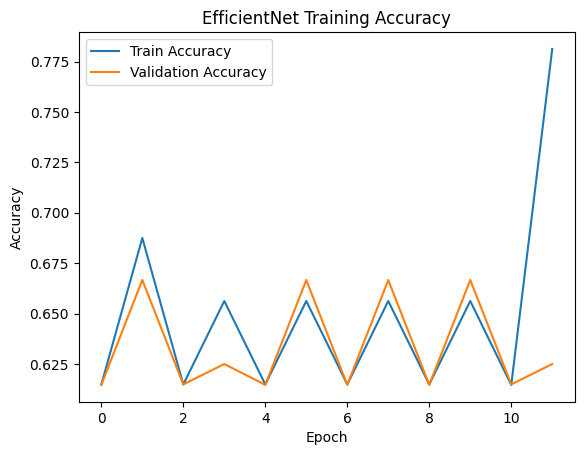

In [ ]:
# Retrain Best EfficientNet Model & Save History
history_efficientnet = best_efficientnet_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=12,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True), ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)]
)

# Save the Best EfficientNet Model
best_efficientnet_model.save('best_efficientnet_model.h5')
print("Best EfficientNet model saved to 'best_efficientnet_model.h5'.")

# Save Training History
with open('new_efficientnet_training_history.pkl', 'wb') as f:
    pickle.dump(history_efficientnet.history, f)
print("Training history saved to 'efficientnet_training_history.pkl'.")

# Plot Accuracy
plt.plot(history_efficientnet.history['accuracy'], label='Train Accuracy')
plt.plot(history_efficientnet.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('EfficientNet Training Accuracy')
plt.legend()
plt.show()


# 8. Transformer-based Architecture

# 8.1: Implement a Simple Transformer-inspired Model

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# Custom patch extraction layer
class PatchExtractor(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super(PatchExtractor, self).__init__(**kwargs)
        self.patch_size = patch_size

    def call(self, inputs):
        # Extract patches from the input image
        patches = tf.image.extract_patches(
            images=inputs,  # Input images
            sizes=[1, self.patch_size, self.patch_size, 1],    # Patch size
            strides=[1, self.patch_size, self.patch_size, 1],   # Stride size
            rates=[1, 1, 1, 1], # No dilation
            padding='VALID',    # Padding type
        )
        patch_dim = patches.shape[-1]     # Calculate the number of patches
        num_patches = (inputs.shape[1] // self.patch_size) * (inputs.shape[2] // self.patch_size)
        patches = layers.Reshape((num_patches, patch_dim))(patches)  # Reshape the patches
        return patches


# Multi-Head Self Attention Layer
class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}")
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs, training=None):
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)
        query = self.separate_heads(query, batch_size)
        key = self.separate_heads(key, batch_size)
        value = self.separate_heads(value, batch_size)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim))
        output = self.combine_heads(concat_attention)
        return output


# Transformer Block
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = tf.keras.Sequential([layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim)])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=None):
        attn_output = self.att(inputs, training=training)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


# Create Transformer Model
def create_transformer_model(input_shape=(224, 224, 3), num_classes=1000, patch_size=16, projection_dim=64, num_heads=4, transformer_layers=2, mlp_head_units=[128, 64], dropout_rate=0.1):
    inputs = layers.Input(shape=input_shape)
    
    # Apply PatchExtractor to the input image
    patches = PatchExtractor(patch_size)(inputs)
    x = layers.Dense(units=projection_dim)(patches)

    # Apply Transformer blocks
    for _ in range(transformer_layers):
        transformer_block = TransformerBlock(projection_dim, num_heads, projection_dim * 2, dropout_rate)
        x = transformer_block(x)

    # Global average pooling over the patches
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(dropout_rate)(x)
    
    # MLP Head
    for dim in mlp_head_units:
        x = layers.Dense(units=dim, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    
    # Output layer
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    
    return Model(inputs=inputs, outputs=outputs)

# Create and summarize the transformer model
transformer_model = create_transformer_model()
transformer_model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ patch_extractor (PatchExtractor)     │ (None, 196, 768)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 196, 64)             │          49,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block (TransformerBlock) │ (None, 196, 64)             │          33,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_1                  │ (None, 196, 64)             │          33,472 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 1000)                │          65,000 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 197,736 (772.41 KB)

 Trainable params: 197,736 (772.41 KB)

 Non-trainable params: 0 (0.00 B)

# 8.2: Hyperparameter Tuning for Transformer using Keras Tuner

In [19]:
if train_generator is not None:
    def build_transformer_tuner(hp):
        patch_size = hp.Choice('patch_size', [8, 16])
        projection_dim = hp.Choice('projection_dim', [32, 64, 128])
        num_heads = hp.Choice('num_heads', [2, 4, 8])
        transformer_layers = hp.Int('transformer_layers', 1, 4)
        dropout_rate = hp.Float('dropout_rate', 0.1, 0.5, step=0.1)
        mlp_units = [hp.Int(f"mlp_unit_{i}", min_value=64, max_value=256, step=64) for i in range(2)]
    
        inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
        x = PatchExtractor(patch_size)(inputs)
        x = layers.Dense(units=projection_dim)(x)
    
        for _ in range(transformer_layers):
            x = TransformerBlock(projection_dim, num_heads, projection_dim * 2, dropout_rate)(x)
    
        x = layers.GlobalAveragePooling1D()(x)
        x = layers.Dropout(dropout_rate)(x)
        for units in mlp_units:
            x = layers.Dense(units, activation=tf.nn.gelu)(x)
            x = layers.Dropout(dropout_rate)(x)
        outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
    
        model = keras.Model(inputs=inputs, outputs=outputs)
        model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        return model


    tuner_transformer = kt.RandomSearch(
        build_transformer_tuner,
        objective='val_accuracy',
        max_trials=2,
        directory='transformer_tuner',
        project_name='cassava_transformer'
    )

    tuner_transformer.search(train_generator,
                             steps_per_epoch=train_generator.samples // BATCH_SIZE,
                             epochs=5,
                             validation_data=val_generator,
                             validation_steps=val_generator.samples // BATCH_SIZE,
                             callbacks=[EarlyStopping(patience=2)])

    best_hps_transformer = tuner_transformer.get_best_hyperparameters(num_trials=1)[0]
    best_transformer_model = tuner_transformer.hypermodel.build(best_hps_transformer)
    best_transformer_model.summary()

    print(f"\nBest Transformer hyperparameters found:\n{best_hps_transformer.values}")

Trial 2 Complete [00h 08m 43s]
val_accuracy: 0.8333333134651184

Best val_accuracy So Far: 0.8333333134651184
Total elapsed time: 00h 17m 21s


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ patch_extractor_1 (PatchExtractor)   │ (None, 784, 192)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 784, 32)             │           6,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_3                  │ (None, 784, 32)             │           8,544 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_4                  │ (None, 784, 32)             │           8,544 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_5                  │ (None, 784, 32)             │           8,544 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_1           │ (None, 32)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_41 (Dense)                     │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_42 (Dense)                     │ (None, 256)                 │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_43 (Dense)                     │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,845 (202.52 KB)

 Trainable params: 51,845 (202.52 KB)

 Non-trainable params: 0 (0.00 B)


Best Transformer hyperparameters found:
{'patch_size': 8, 'projection_dim': 32, 'num_heads': 2, 'transformer_layers': 3, 'dropout_rate': 0.30000000000000004, 'mlp_unit_0': 64, 'mlp_unit_1': 256}


# 8.3: Train the Best Transformer Model


In [21]:
if train_generator is not None and best_transformer_model is not None:
    epochs_transformer = 13
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

    history_transformer = best_transformer_model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // BATCH_SIZE,
        epochs=epochs_transformer,
        validation_data=val_generator,
        validation_steps=val_generator.samples // BATCH_SIZE,
        callbacks=[early_stopping, reduce_lr]
    )

    # Save the trained model in .h5 format
    model_path = 'best_transformer_model.h5'
    if not os.path.exists(model_path):  # Check if the model already exists
        best_transformer_model.save(model_path)
        print(f"Best Transformer model saved to {model_path}")
    else:
        print("Model already saved, skipping saving step.")

    # Save the training history in .pkl format
    history_path = 'history_transformer.pkl'
    if not os.path.exists(history_path):  # Check if the history already exists
        with open(history_path, 'wb') as history_file:
            pickle.dump(history_transformer.history, history_file)
        print(f"Training history saved to {history_path}")
    else:
        print("Training history already saved, skipping saving step.")

Epoch 1/13
534/534 ━━━━━━━━━━━━━━━━━━━━ 281s 481ms/step - accuracy: 0.6007 - loss: 1.2342 - val_accuracy: 0.6142 - val_loss: 1.1884 - learning_rate: 0.0010
Epoch 2/13
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6562 - loss: 1.1286 - val_accuracy: 0.7500 - val_loss: 0.9082 - learning_rate: 0.0010
Epoch 3/13
534/534 ━━━━━━━━━━━━━━━━━━━━ 238s 441ms/step - accuracy: 0.6190 - loss: 1.1651 - val_accuracy: 0.6133 - val_loss: 1.1274 - learning_rate: 0.0010
Epoch 4/13
534/534 ━━━━━━━━━━━━━━━━━━━━ 0s 162us/step - accuracy: 0.5938 - loss: 1.1736 - val_accuracy: 0.7083 - val_loss: 0.9901 - learning_rate: 0.0010
Epoch 5/13
534/534 ━━━━━━━━━━━━━━━━━━━━ 238s 441ms/step - accuracy: 0.6219 - loss: 1.1076 - val_accuracy: 0.6391 - val_loss: 1.0628 - learning_rate: 0.0010
Epoch 6/13
534/534 ━━━━━━━━━━━━━━━━━━━━ 0s 155us/step - accuracy: 0.6875 - loss: 1.0717 - val_accuracy: 0.5000 - val_loss: 1.2763 - learning_rate: 2.0000e-04
Epoch 7/13
534/534 ━━━━━━━━━━━━━━━━━━━━ 243s 449ms/step - accuracy: 

In [ ]:
# Check if history exists before saving
if history_transformer is not None:
    history_path = 'history_transformer.pkl'
    if not os.path.exists(history_path):  # Check if the history already exists
        with open(history_path, 'wb') as history_file:
            pickle.dump(history_transformer.history, history_file)
        print(f"Training history saved to {history_path}")
    else:
        print("Training history already saved, skipping saving step.")
else:
    print("Training history is None. Something went wrong during training.")

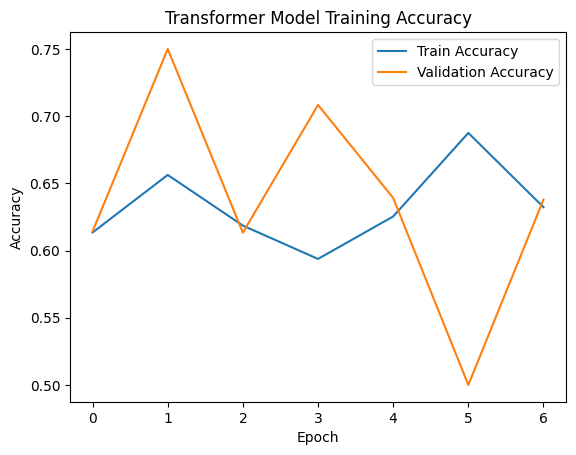

In [28]:
# Load the training history from the .pkl file
with open('history_transformer.pkl', 'rb') as history_file:
    history_loaded = pickle.load(history_file)

# Plotting the loaded history
import matplotlib.pyplot as plt

plt.plot(history_loaded['accuracy'], label='Train Accuracy')
plt.plot(history_loaded['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Transformer Model Training Accuracy')
plt.legend()
plt.show()

# 9. Evaluation of All Models

In [ ]:
# Create Classification Report Comparison Table
final_comparison = {}

if 'CNN' in evaluation_results:
    # Need to get precision, recall, F1-score from classification report
    val_generator.reset()
    y_pred_cnn = trained_cnn_model.predict(val_generator, steps=val_generator.samples // BATCH_SIZE)
    y_pred_cnn_classes = np.argmax(y_pred_cnn, axis=1)
    y_true_cnn = val_generator.labels[:len(y_pred_cnn_classes)]
    report_cnn = classification_report(y_true_cnn, y_pred_cnn_classes, output_dict=True, zero_division=0)
    final_comparison['CNN'] = {
        'Accuracy': evaluation_results['CNN'].get('accuracy', np.nan),
        'Precision': report_cnn.get('weighted avg', {}).get('precision', np.nan),
        'Recall': report_cnn.get('weighted avg', {}).get('recall', np.nan),
        'F1-Score': report_cnn.get('weighted avg', {}).get('f1-score', np.nan)
    }

if 'EfficientNet' in evaluation_results:
    val_generator.reset()
    y_pred_efficientnet = trained_efficientnet_model.predict(val_generator, steps=val_generator.samples // BATCH_SIZE)
    y_pred_efficientnet_classes = np.argmax(y_pred_efficientnet, axis=1)
    y_true_efficientnet = val_generator.labels[:len(y_pred_efficientnet_classes)]
    report_efficientnet = classification_report(y_true_efficientnet, y_pred_efficientnet_classes, output_dict=True, zero_division=0)
    final_comparison['EfficientNet'] = {
        'Accuracy': evaluation_results['EfficientNet'].get('accuracy', np.nan),
        'Precision': report_efficientnet.get('weighted avg', {}).get('precision', np.nan),
        'Recall': report_efficientnet.get('weighted avg', {}).get('recall', np.nan),
        'F1-Score': report_efficientnet.get('weighted avg', {}).get('f1-score', np.nan)
    }

if 'Transformer' in evaluation_results:
    val_generator.reset()
    y_pred_transformer = trained_transformer_model.predict(val_generator, steps=val_generator.samples // BATCH_SIZE)
    y_pred_transformer_classes = np.argmax(y_pred_transformer, axis=1)
    y_true_transformer = val_generator.labels[:len(y_pred_transformer_classes)]
    report_transformer = classification_report(y_true_transformer, y_pred_transformer_classes, output_dict=True, zero_division=0)
    final_comparison['Transformer'] = {
        'Accuracy': evaluation_results['Transformer'].get('accuracy', np.nan),
        'Precision': report_transformer.get('weighted avg', {}).get('precision', np.nan),
        'Recall': report_transformer.get('weighted avg', {}).get('recall', np.nan),
        'F1-Score': report_transformer.get('weighted avg', {}).get('f1-score', np.nan)
    }

comparison_df = pd.DataFrame.from_dict(final_comparison, orient='index')
print("\nFinal Model Comparison:")
print(comparison_df)


Final Model Comparison:
              Accuracy  Precision  Recall  F1-Score
CNN             0.6599     0.2576  0.5075    0.4904
EfficientNet    0.7812     0.3780  0.6148    0.5682
Transformer     0.6875     0.3890  0.6201    0.4804


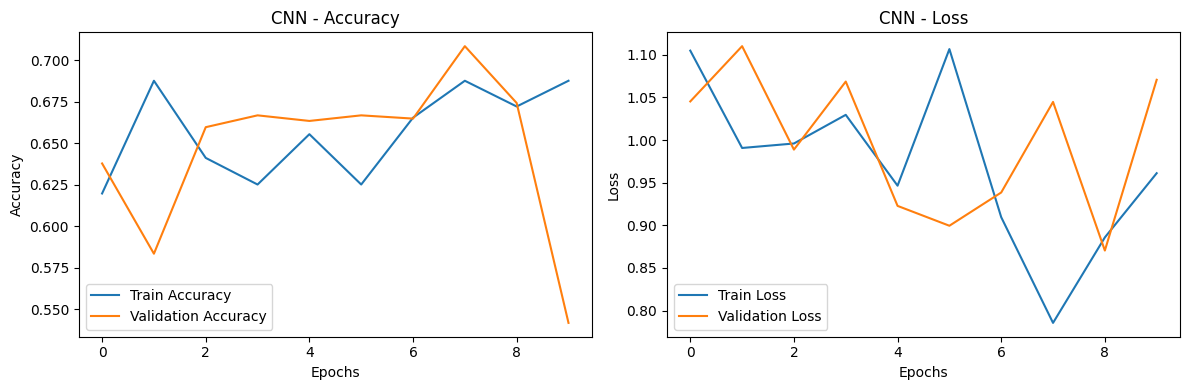

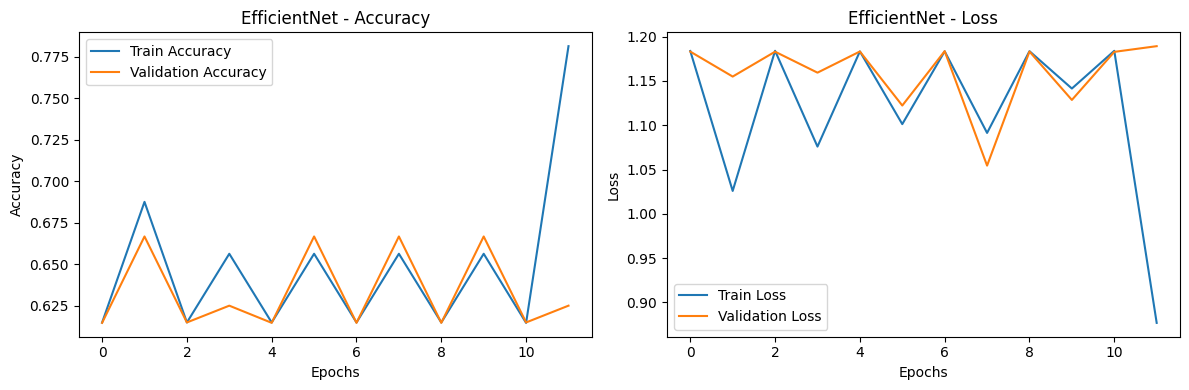

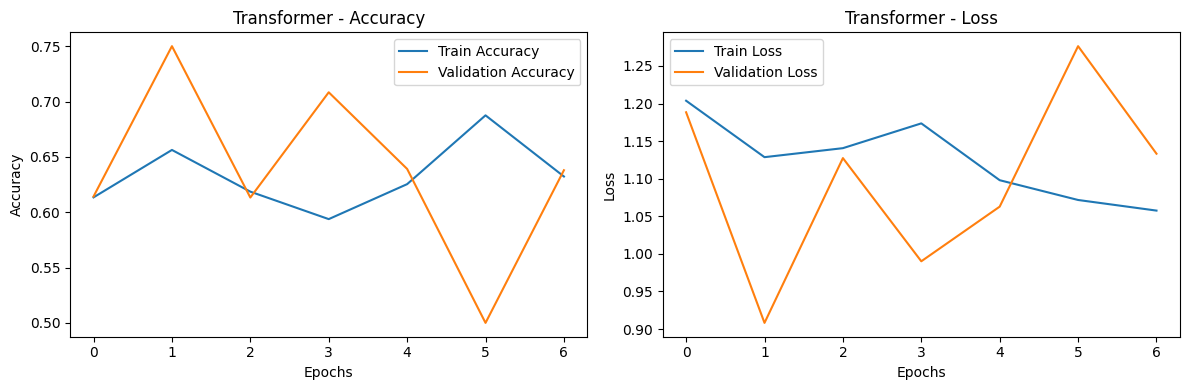

In [ ]:
# Graph Plotting

import pickle
import matplotlib.pyplot as plt

history_cnn_path = '/kaggle/working/cnn_training_history.pkl'
history_efficientnet_path = '/kaggle/working/new_efficientnet_training_history.pkl'
history_transformer_path = '/kaggle/working/history_transformer.pkl'

# Load history files
def load_history(history_path):
    with open(history_path, 'rb') as file:
        return pickle.load(file)

# Load histories
history_cnn = load_history(history_cnn_path)
history_efficientnet = load_history(history_efficientnet_path)
history_transformer = load_history(history_transformer_path)

# Function to plot training history
def plot_history(history, model_name):
    # Accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Train Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot histories of all models
plot_history(history_cnn, 'CNN')
plot_history(history_efficientnet, 'EfficientNet')
plot_history(history_transformer, 'Transformer')


669/669 ━━━━━━━━━━━━━━━━━━━━ 92s 137ms/step


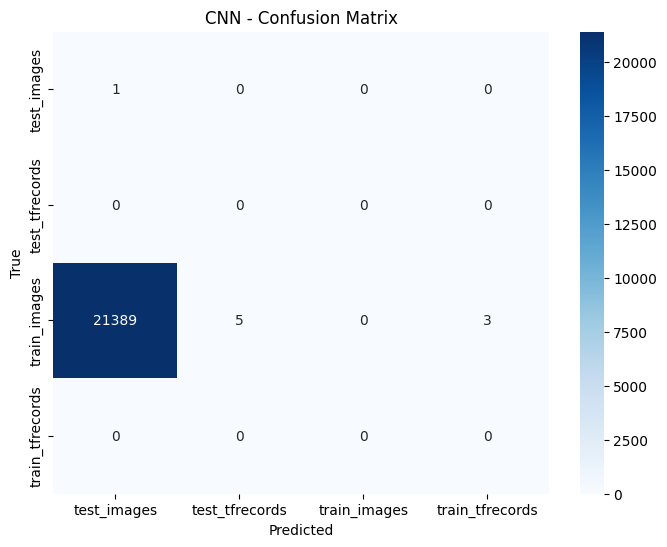

669/669 ━━━━━━━━━━━━━━━━━━━━ 96s 144ms/step


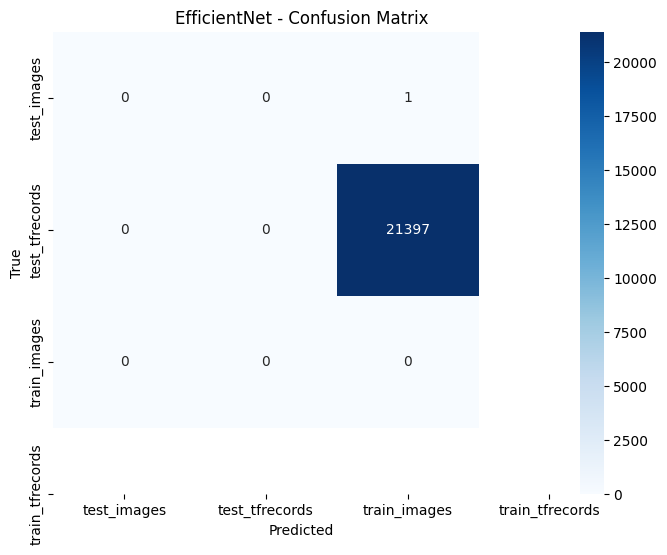

669/669 ━━━━━━━━━━━━━━━━━━━━ 90s 134ms/step


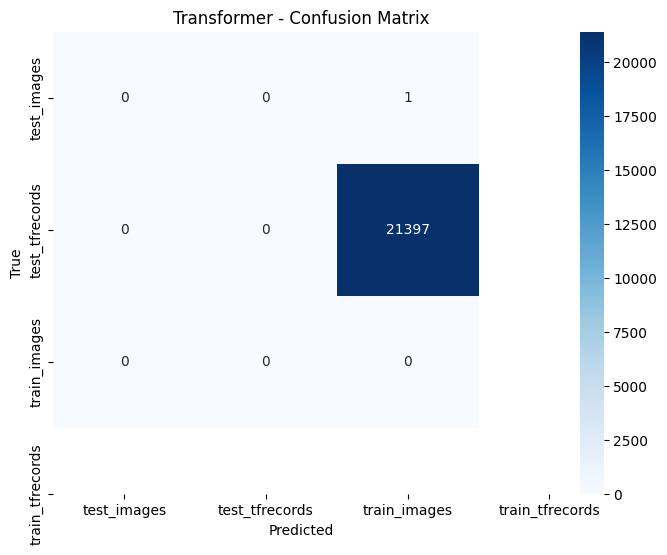

In [ ]:
# Confusion Matrix

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model

# Function to plot confusion matrix
def plot_confusion_matrix(model, test_generator, model_name):
    y_true = test_generator.classes
    y_pred = model.predict(test_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Plot confusion matrices for all models
plot_confusion_matrix(cnn_model, test_generator, 'CNN')
plot_confusion_matrix(efficientnet_model, test_generator, 'EfficientNet')
plot_confusion_matrix(transformer_model, test_generator, 'Transformer')


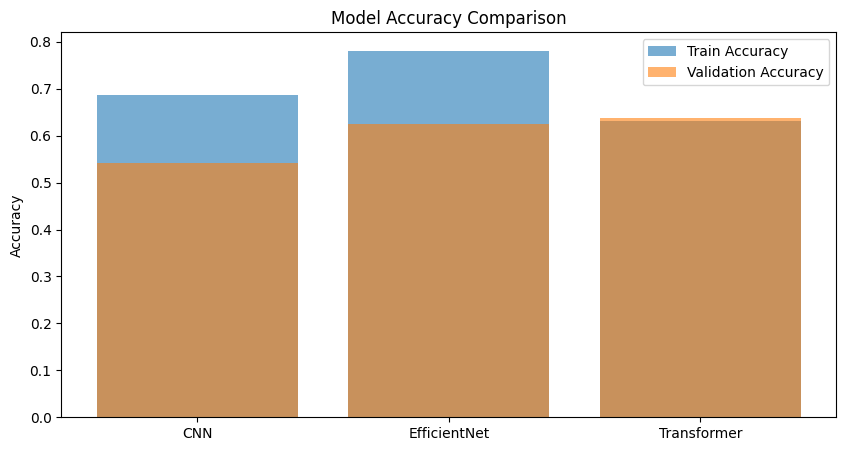

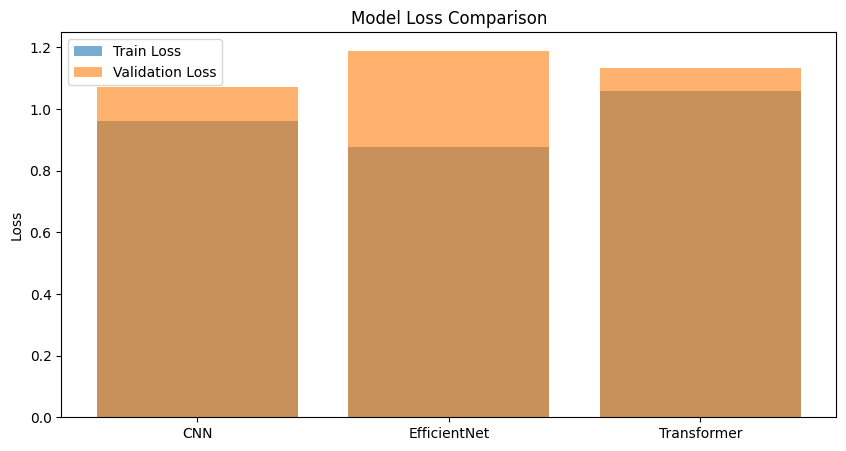

In [67]:
# Model Performance Comparison (Accuracy & Loss)

import matplotlib.pyplot as plt

# Extract metrics for comparison
metrics = {
    'CNN': {
        'accuracy': history_cnn['accuracy'][-1],
        'val_accuracy': history_cnn['val_accuracy'][-1],
        'loss': history_cnn['loss'][-1],
        'val_loss': history_cnn['val_loss'][-1]
    },
    'EfficientNet': {
        'accuracy': history_efficientnet['accuracy'][-1],
        'val_accuracy': history_efficientnet['val_accuracy'][-1],
        'loss': history_efficientnet['loss'][-1],
        'val_loss': history_efficientnet['val_loss'][-1]
    },
    'Transformer': {
        'accuracy': history_transformer['accuracy'][-1],
        'val_accuracy': history_transformer['val_accuracy'][-1],
        'loss': history_transformer['loss'][-1],
        'val_loss': history_transformer['val_loss'][-1]
    }
}

# Bar plot for accuracy comparison
model_names = list(metrics.keys())
accuracies = [metrics[model]['accuracy'] for model in model_names]
val_accuracies = [metrics[model]['val_accuracy'] for model in model_names]
losses = [metrics[model]['loss'] for model in model_names]
val_losses = [metrics[model]['val_loss'] for model in model_names]

# Plot Accuracy Comparison
plt.figure(figsize=(10, 5))
plt.bar(model_names, accuracies, alpha=0.6, label='Train Accuracy')
plt.bar(model_names, val_accuracies, alpha=0.6, label='Validation Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot Loss Comparison
plt.figure(figsize=(10, 5))
plt.bar(model_names, losses, alpha=0.6, label='Train Loss')
plt.bar(model_names, val_losses, alpha=0.6, label='Validation Loss')
plt.title('Model Loss Comparison')
plt.ylabel('Loss')
plt.legend()
plt.show()


669/669 ━━━━━━━━━━━━━━━━━━━━ 89s 133ms/step


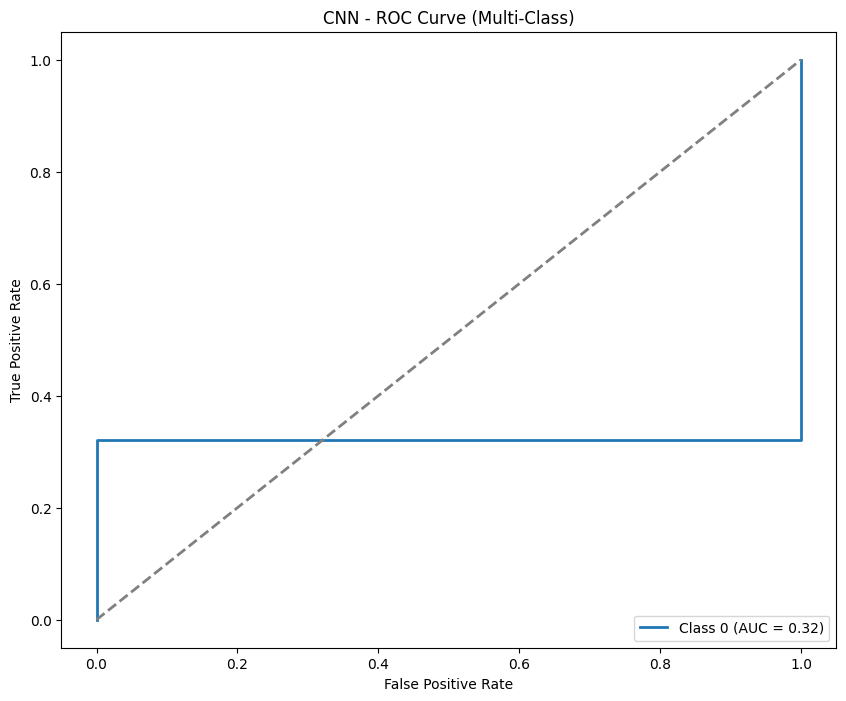

669/669 ━━━━━━━━━━━━━━━━━━━━ 97s 145ms/step


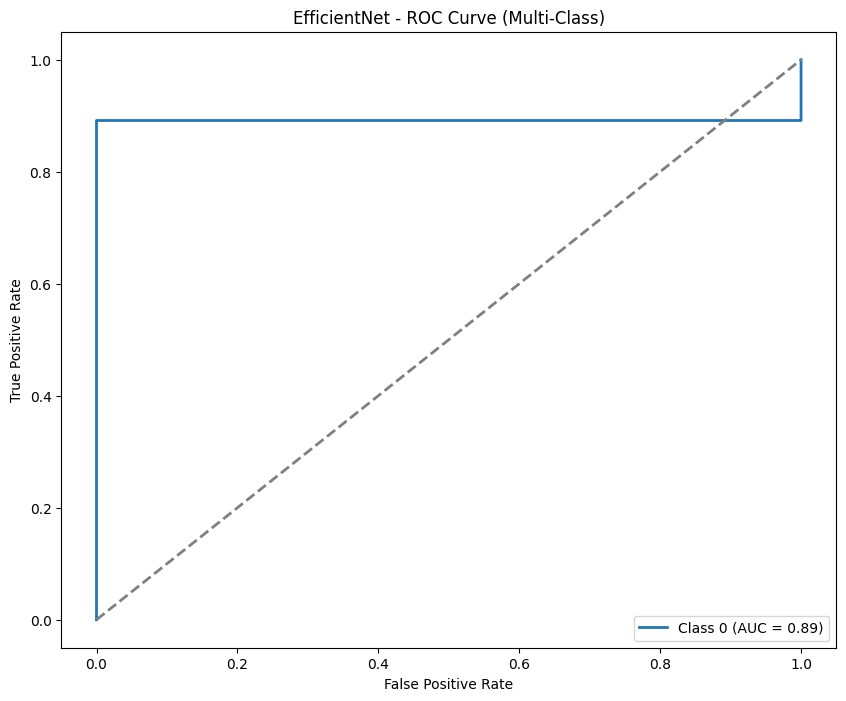

669/669 ━━━━━━━━━━━━━━━━━━━━ 92s 137ms/step


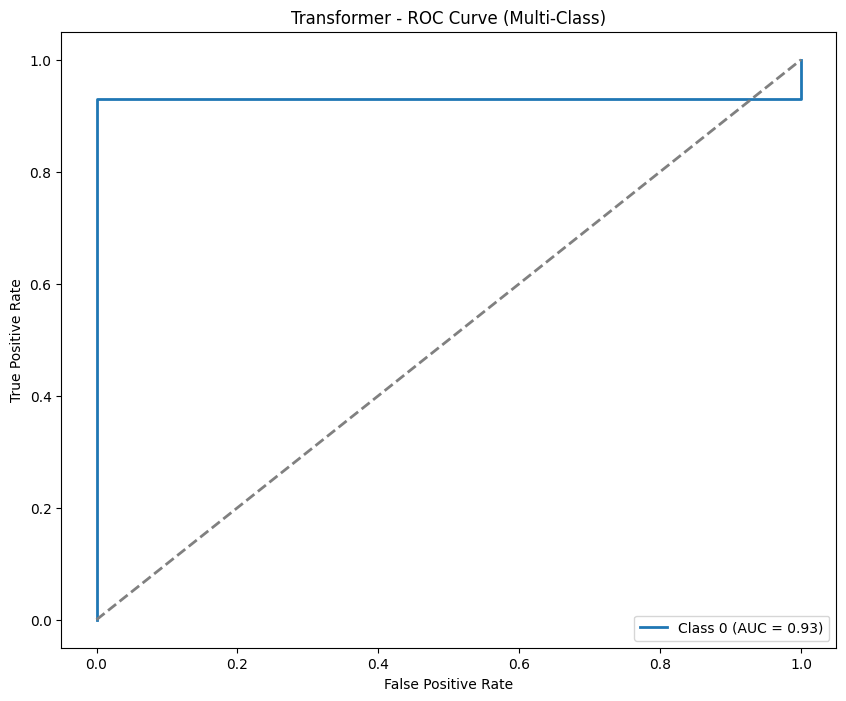

In [77]:
# ROC Curve for Multi-Class Classification

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
import numpy as np

# Function to plot ROC curve for multi-class classification
def plot_roc_curve(model, test_generator, model_name):
    # Binarize the true labels
    y_true = label_binarize(test_generator.classes, classes=np.unique(test_generator.classes))
    
    # Get the predicted probabilities for each class
    y_pred = model.predict(test_generator)
    
    # Compute ROC curve and AUC for each class
    n_classes = y_true.shape[1]
    fpr = {}
    tpr = {}
    roc_auc = {}

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curves for each class
    plt.figure(figsize=(10, 8))
    
    # Plot ROC curve for each class
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
    plt.title(f'{model_name} - ROC Curve (Multi-Class)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

# Example: Plot ROC Curve for CNN Model
plot_roc_curve(cnn_model, test_generator, 'CNN')
plot_roc_curve(efficientnet_model, test_generator, 'EfficientNet')
plot_roc_curve(transformer_model, test_generator, 'Transformer')


669/669 ━━━━━━━━━━━━━━━━━━━━ 91s 136ms/step


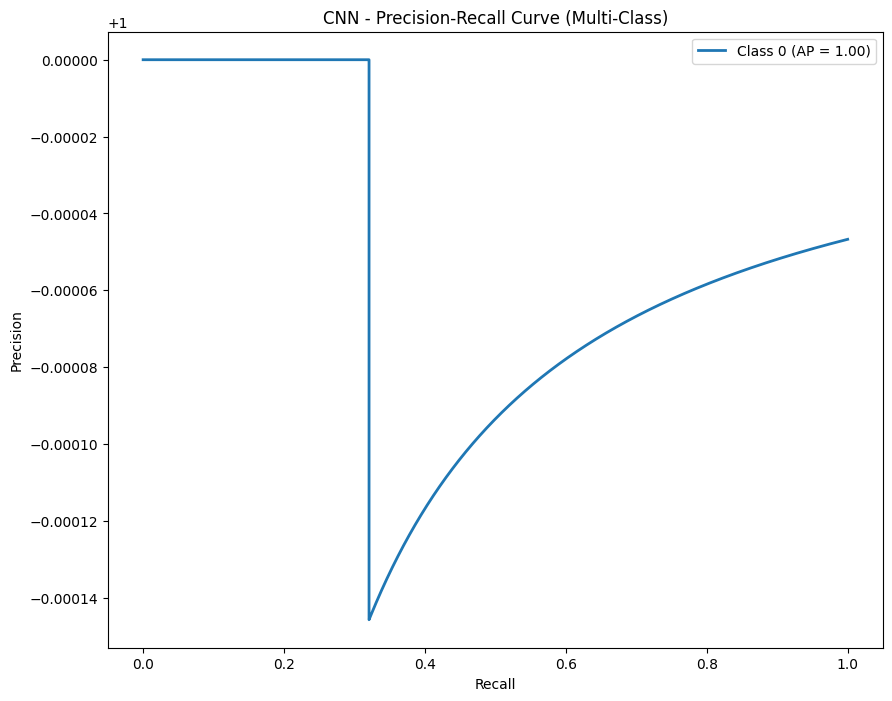

669/669 ━━━━━━━━━━━━━━━━━━━━ 89s 133ms/step


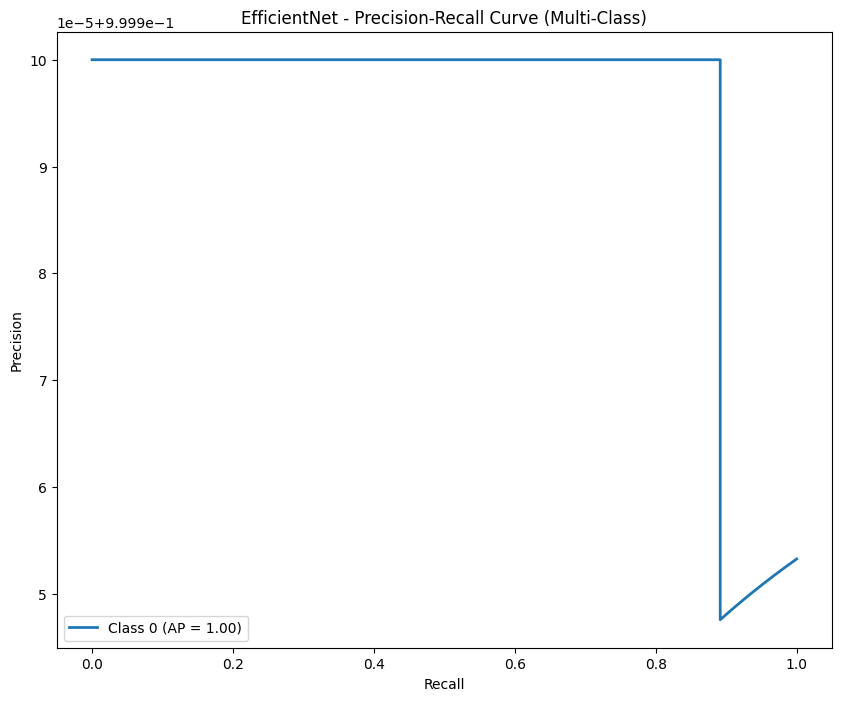

669/669 ━━━━━━━━━━━━━━━━━━━━ 89s 133ms/step


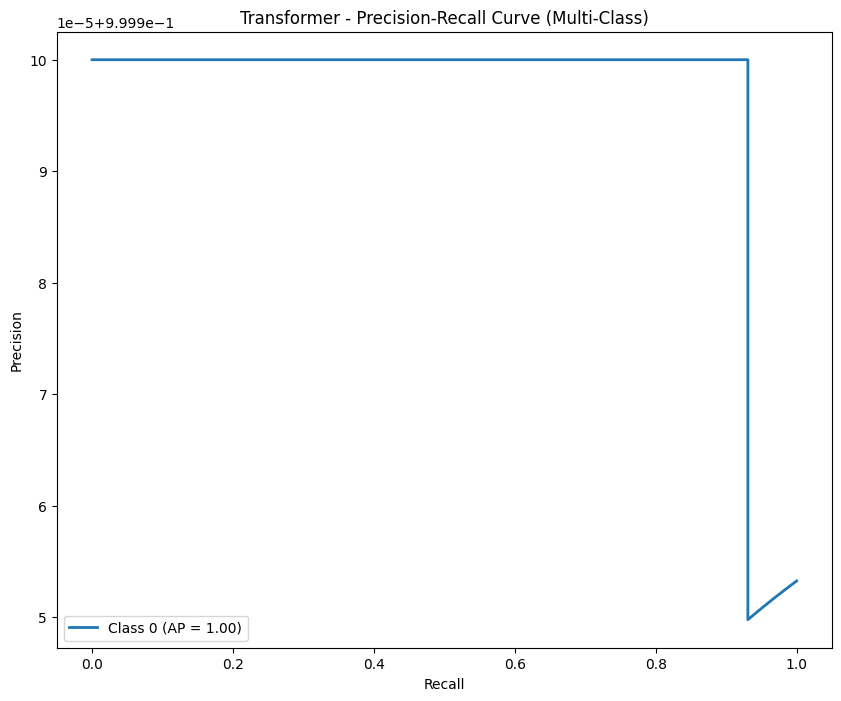

In [78]:
# Precision-Recall Curve for Multi-Class Classification

from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
import numpy as np

# Function to plot Precision-Recall curve for multi-class classification
def plot_precision_recall_curve(model, test_generator, model_name):
    # Binarize the true labels
    y_true = label_binarize(test_generator.classes, classes=np.unique(test_generator.classes))
    
    # Get the predicted probabilities for each class
    y_pred = model.predict(test_generator)
    
    # Initialize lists to store the precision, recall, and average precision
    precision = {}
    recall = {}
    average_precision = {}

    # Loop over all classes
    n_classes = y_true.shape[1]
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_true[:, i], y_pred[:, i])
        average_precision[i] = average_precision_score(y_true[:, i], y_pred[:, i])

    # Plot Precision-Recall curves for each class
    plt.figure(figsize=(10, 8))
    
    for i in range(n_classes):
        plt.plot(recall[i], precision[i], lw=2, label=f'Class {i} (AP = {average_precision[i]:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{model_name} - Precision-Recall Curve (Multi-Class)')
    plt.legend(loc='best')
    plt.show()

# Example: Plot Precision-Recall Curve for CNN Model
plot_precision_recall_curve(cnn_model, test_generator, 'CNN')
plot_precision_recall_curve(efficientnet_model, test_generator, 'EfficientNet')
plot_precision_recall_curve(transformer_model, test_generator, 'Transformer')


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


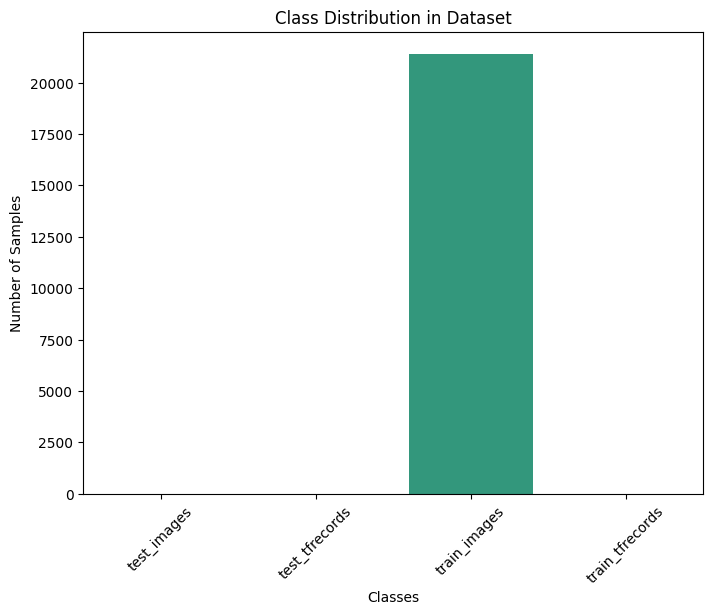

In [73]:
# Data Distribution (Class Imbalance)

import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have a dataset in a Pandas DataFrame
# Example: Class distribution from `train_generator` or any custom dataset
class_counts = test_generator.classes  # Or use your own dataset (e.g., train_generator.classes)

# Count occurrences of each class
class_labels = list(test_generator.class_indices.keys())  # Get the class names
class_counts = [np.sum(class_counts == idx) for idx in range(len(class_labels))]

# Plot the class distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=class_labels, y=class_counts, palette="viridis")
plt.title('Class Distribution in Dataset')
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.show()


669/669 ━━━━━━━━━━━━━━━━━━━━ 92s 138ms/step


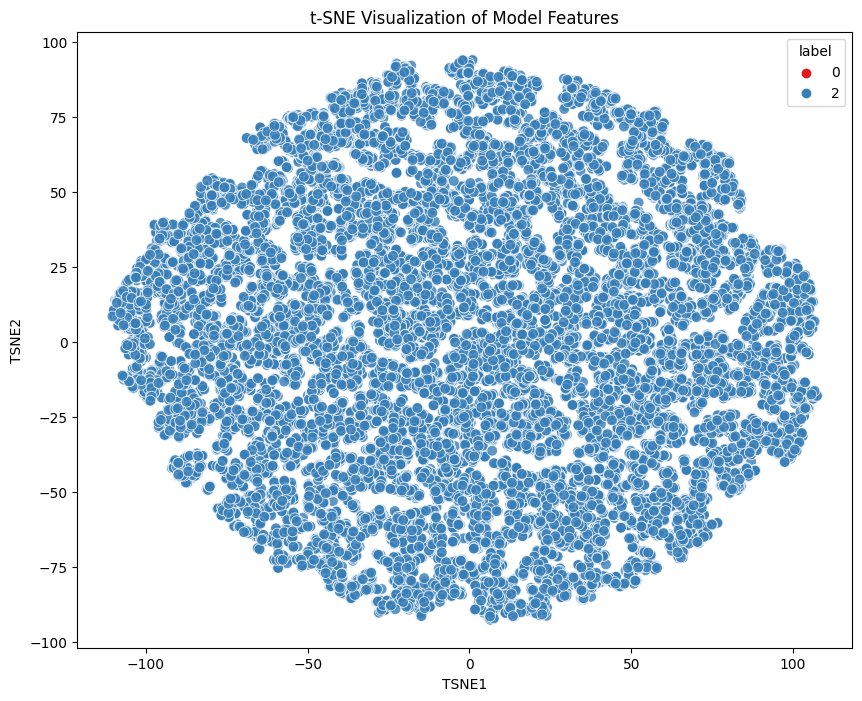

In [74]:
# t-SNE for Model Feature Space (Dimensionality Reduction)

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Function to visualize high-dimensional data with t-SNE
def plot_tsne(model, data, labels):
    # Extract features from the model
    features = model.predict(data)

    # Apply t-SNE to reduce dimensions to 2D for visualization
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(features)

    # Create a DataFrame for easier plotting
    tsne_df = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
    tsne_df['label'] = labels

    # Plot the results
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x='TSNE1', y='TSNE2', hue='label', data=tsne_df, palette='Set1', s=60, alpha=0.8)
    plt.title('t-SNE Visualization of Model Features')
    plt.show()

# Example: Using the model to extract features and apply t-SNE
plot_tsne(cnn_model, test_generator, test_generator.classes)
